In [68]:
#Importing 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Load your dataset
data = pd.read_csv('C:/Users/user/Desktop/MSc Folder/Masters Research/Modelling Data/Modelling data.csv')

# Assuming your file has columns named 'wind_speed', 'wind_direction', 'theoretical_power_curve', 'lv_active_power'
X = data.drop(columns=['Compressive Strength'])
y = data['Compressive Strength']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [71]:
# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
# Perform hyperparameter tuning using GridSearchCV
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [72]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [73]:
# Train the model with the best parameters
best_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [74]:
# Evaluate the model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on test set: {mae}')

Mean Absolute Error on test set: 3.998661406233504


In [75]:
# Compute metrics
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² (Goodness of Fit): {r2:.2f}")

Mean Absolute Percentage Error (MAPE): 0.16%
Root Mean Square Error (RMSE): 6.12
Mean Absolute Error (MAE): 4.00
R² (Goodness of Fit): 0.83


In [76]:
# Convert predictions to a DataFrame for better visualization
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())

     Actual  Predicted
19    48.74  50.169449
42    24.00  25.108622
153   49.89  48.448936
78    24.00  25.834469
145   41.92  39.280418


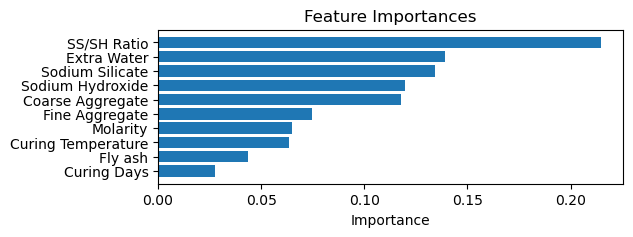

In [77]:
# Plot feature importances
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(6, 2))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Importance')
plt.show()

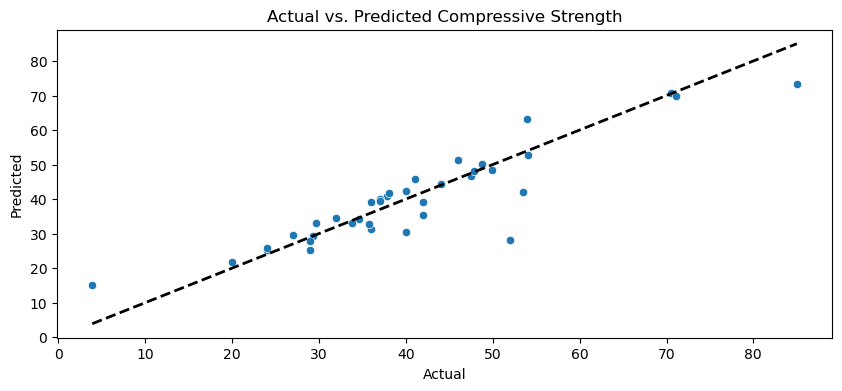

In [78]:
# Visualize actual vs. predicted values
plt.figure(figsize=(10, 4))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Compressive Strength')
plt.show()

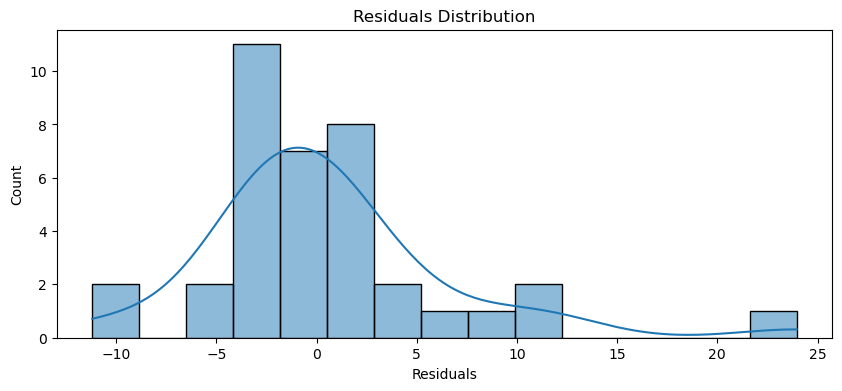

In [79]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 4))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()

Z-Score Anomalies:
    Fly ash  Sodium Silicate  Sodium Hydroxide  Molarity  Coarse Aggregate  \
69    408.0            103.0              41.0        14            1201.0   
72    408.0            103.0              41.0        16            1201.0   

    Fine Aggregate  Curing Days  Curing Temperature  SS/SH Ratio  Extra Water  \
69           647.0         13.0                  60          2.0         10.3   
72           647.0         14.0                  90          2.0         18.5   

    Compressive Strength   z_score  
69                  85.0  3.208911  
72                  84.0  3.136867  
Z-Score Anomalies:
    Fly ash  Sodium Silicate  Sodium Hydroxide  Molarity  Coarse Aggregate  \
69    408.0            103.0              41.0        14            1201.0   
72    408.0            103.0              41.0        16            1201.0   

    Fine Aggregate  Curing Days  Curing Temperature  SS/SH Ratio  Extra Water  \
69           647.0         13.0                  60     

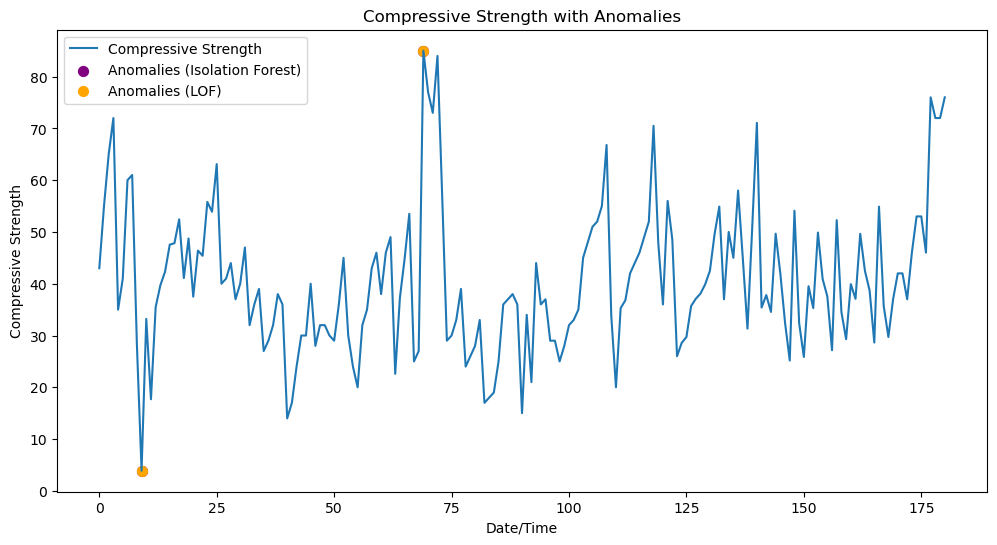

In [80]:
from scipy import stats

# Calculate z-scores
data['z_score'] = np.abs(stats.zscore(data['Compressive Strength']))

# Identify anomalies
threshold = 3
anomalies_z = data[data['z_score'] > threshold]
print(f"Z-Score Anomalies:\n{anomalies_z}")

# Remove the z_score column after use
data.drop(columns=['z_score'], inplace=True)

# Calculate z-scores
data['z_score'] = np.abs(stats.zscore(data['Compressive Strength']))

# Identify anomalies
threshold = 3
anomalies_z = data[data['z_score'] > threshold]
print(f"Z-Score Anomalies:\n{anomalies_z}")

# Remove the z_score column after use
data.drop(columns=['z_score'], inplace=True)

# Calculate IQR
Q1 = data['Compressive Strength'].quantile(0.25)
Q3 = data['Compressive Strength'].quantile(0.75)
IQR = Q3 - Q1

# Identify anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
anomalies_iqr = data[(data['Compressive Strength'] < lower_bound) | (data['Compressive Strength'] > upper_bound)]
print(f"IQR Anomalies:\n{anomalies_iqr}")

from sklearn.ensemble import IsolationForest

# Fit the model
iso_forest = IsolationForest(contamination=0.01)  # 1% contamination rate
data['anomaly_iso'] = iso_forest.fit_predict(data[['Compressive Strength']])

# Identify anomalies
anomalies_iso = data[data['anomaly_iso'] == -1]
print(f"Isolation Forest Anomalies:\n{anomalies_iso}")

# Remove the anomaly_iso column after use
data.drop(columns=['anomaly_iso'], inplace=True)

from sklearn.neighbors import LocalOutlierFactor

# Fit the model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)  # 1% contamination rate
data['anomaly_lof'] = lof.fit_predict(data[['Compressive Strength']])

# Identify anomalies
anomalies_lof = data[data['anomaly_lof'] == -1]
print(f"Local Outlier Factor Anomalies:\n{anomalies_lof}")

# Remove the anomaly_lof column after use
data.drop(columns=['anomaly_lof'], inplace=True)

import matplotlib.pyplot as plt

# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Compressive Strength'], label='Compressive Strength')

# Plot anomalies detected by Z-Score
#plt.scatter(anomalies_z.index, anomalies_z['LV ActivePower'], color='red', label='Anomalies (Z-Score)', s=50)

# Plot anomalies detected by IQR
#plt.scatter(anomalies_iqr.index, anomalies_iqr['LV ActivePower'], color='green', label='Anomalies (IQR)', s=50)

# Plot anomalies detected by Isolation Forest
plt.scatter(anomalies_iso.index, anomalies_iso['Compressive Strength'], color='purple', label='Anomalies (Isolation Forest)', s=50)

# Plot anomalies detected by LOF
plt.scatter(anomalies_lof.index, anomalies_lof['Compressive Strength'], color='orange', label='Anomalies (LOF)', s=50)

plt.xlabel('Date/Time')
plt.ylabel('Compressive Strength')
plt.title('Compressive Strength with Anomalies')
plt.legend()
plt.show()